# Discounted Cash Flow Valuation of Repsol (To Equity)

Equity Value = Present Value of Free Future Cash Flow to Equity

V₀ = FCF ͤ₁ / (1+ re )¹ + FCF ͤ₂ / (1+ re ) ² + FCF ͤ₃ / (1+ re )³ + ...

= ∑ from t = 1 to ∞ FCF ͤₜ / (1+ re )ᵗ

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

FILE_NAME = 'repsol_financials.csv'
df = pd.read_csv(FILE_NAME, index_col=0)

# Filter out the 'Latest Market Data' row, as it doesn't contain annual FCF components
df_annual = df.drop('Latest Market Data', errors='ignore')

# Convert relevant columns to numeric
cols_to_convert = ['Revenue', 'EBIT', 'Depreciation', 'CapEx', 'Taxes', 'Net Working Capital']
for col in cols_to_convert:
    # Ensure the column exists before attempting to convert
    if col in df_annual.columns:
        df_annual[col] = pd.to_numeric(df_annual[col], errors='coerce')

df_annual.dropna(subset=['EBIT', 'Depreciation', 'CapEx', 'Net Working Capital', 'Taxes'], how='all', inplace=True)

print("Annual Financial Data (Preview):")
print(df_annual[['EBIT', 'Taxes', 'Depreciation', 'CapEx', 'Net Working Capital']].head())

Annual Financial Data (Preview):
                    EBIT         Taxes  Depreciation         CapEx  \
2024-12-31  2.673000e+09  5.620000e+08  2.932000e+09  4.725000e+09   
2023-12-31  4.815000e+09  1.081000e+09  2.436000e+09  4.289000e+09   
2022-12-31  7.595000e+09  2.835000e+09  2.339000e+09  3.535000e+09   
2021-12-31  4.735000e+09  1.801000e+09  2.004000e+09  1.902000e+09   

            Net Working Capital  
2024-12-31         5.581000e+09  
2023-12-31         8.234000e+09  
2022-12-31         9.265000e+09  
2021-12-31         5.124000e+09  


In [41]:
# Calculate Change in Net Working Capital (Delta NWC)
# Since yfinance data is usually in descending order (most recent first), we need to reverse the order first.
df_annual_sorted = df_annual.sort_index(ascending=True)

df_annual_sorted['ΔWorkingCapital'] = df_annual_sorted['Net Working Capital'].diff()

df_annual = df_annual_sorted.sort_index(ascending=False)

In [42]:
# Calculate the Effective Tax Rate (Avoid division by zero)
df_annual['TaxRate'] = df_annual.apply(
    lambda row: row['Taxes'] / row['EBIT'] if row['EBIT'] != 0 and row['EBIT'] > 0 else 0.25, # Use a placeholder 25% if EBIT is zero or negative
    axis=1
)

# Cap the Tax Rate at a reasonable level (e.g., 25% to 35%) to prevent unrealistically high or low numbers from one-time items
df_annual['TaxRate'] = df_annual['TaxRate'].clip(lower=0.25, upper=0.35)

# Calculate FCF
df_annual['FCF'] = (
    df_annual['EBIT'] * (1 - df_annual['TaxRate'])  # Net Operating Profit After Tax (NOPAT)
    + df_annual['Depreciation']                     # Add back non-cash charge
    - df_annual['CapEx']                            # Subtract Capital Expenditures
    - df_annual['ΔWorkingCapital']                  # Subtract change in NWC (cash outflow)
)

print("\nFree Cash Flow (FCF) Results:")
# Show the key components and the final FCF for the last 4 years
print(df_annual[['EBIT', 'TaxRate', 'Depreciation', 'CapEx', 'ΔWorkingCapital', 'FCF']].round(2))


Free Cash Flow (FCF) Results:
                    EBIT  TaxRate  Depreciation         CapEx  \
2024-12-31  2.673000e+09     0.25  2.932000e+09  4.725000e+09   
2023-12-31  4.815000e+09     0.25  2.436000e+09  4.289000e+09   
2022-12-31  7.595000e+09     0.35  2.339000e+09  3.535000e+09   
2021-12-31  4.735000e+09     0.35  2.004000e+09  1.902000e+09   

            ΔWorkingCapital           FCF  
2024-12-31    -2.653000e+09  2.864750e+09  
2023-12-31    -1.031000e+09  2.789250e+09  
2022-12-31     4.141000e+09 -4.002500e+08  
2021-12-31              NaN           NaN  


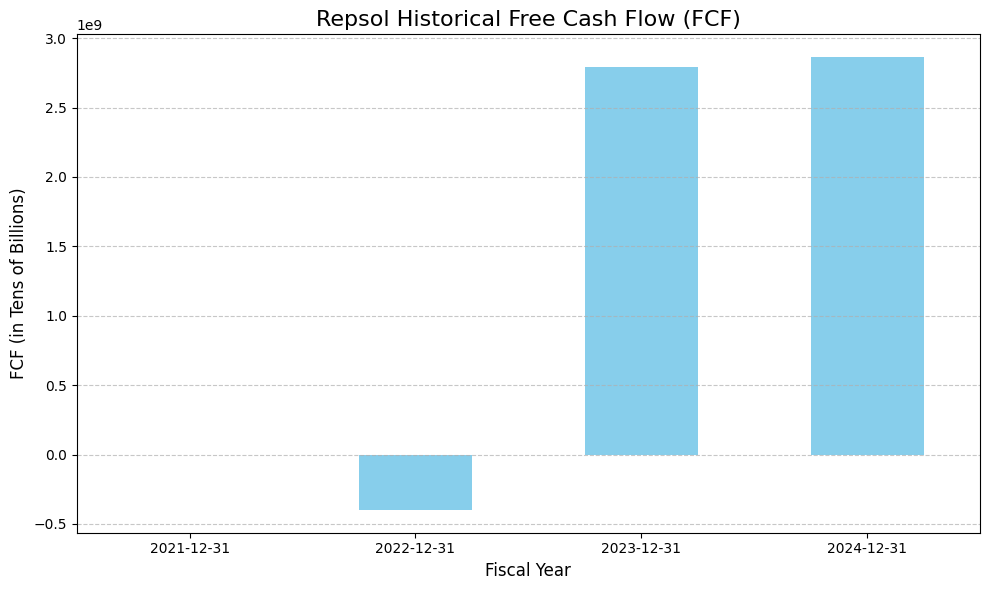

In [43]:
# Generate the Chart
df_annual['FCF'].sort_index(ascending=True).plot(
    kind='bar',
    figsize=(10, 6),
    color='skyblue'
)

# Formatting the plot
plt.title('Repsol Historical Free Cash Flow (FCF)', fontsize=16)
plt.xlabel('Fiscal Year', fontsize=12)
plt.ylabel('FCF (in Tens of Billions)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Forecasting Future FCFs
We will use the latest historical year (2024) as the starting point and project the key FCF components for the next five years (2025 to 2029).

In [44]:
# Define Assumptions
BASE_GROWTH_RATE = 0.05  # Base Case: 5% revenue growth for the next 5 years
TAX_RATE = 0.25          # average or a stable long-term tax rate (25% for simplicity)

# Get the starting values from the latest historical year (2024)
latest_year = df_annual.index[0]
start_data = df_annual.loc[latest_year]

# Key starting values
start_revenue = start_data['Revenue']
start_ebit_margin = start_data['EBIT'] / start_data['Revenue'] if start_data['Revenue'] != 0 else 0.10
# CapEx and NWC as a % of Revenue for forecasting
start_capex_ratio = start_data['CapEx'] / start_data['Revenue'] if start_data['Revenue'] != 0 else 0.05
start_nwc_ratio = start_data['Net Working Capital'] / start_data['Revenue'] if start_data['Revenue'] != 0 else 0.05
# We'll assume Depreciation is a fixed percentage of CapEx (e.g., 80%)
DEP_TO_CAPEX_RATIO = 0.80

print(f"Starting Revenue (2024): ${start_revenue:.2e}")
print(f"Starting EBIT Margin: {start_ebit_margin:.2%}")

Starting Revenue (2024): $5.71e+10
Starting EBIT Margin: 4.68%


In [45]:
# Create the projection period years
projection_years = [f'{y}-12-31' for y in range(2025, 2030)]
proj_df = pd.DataFrame(index=projection_years,
                       columns=['Revenue', 'EBIT', 'Depreciation', 'CapEx', 'ΔWorkingCapital', 'FCF'])

# Initialize the first year's revenue
proj_df.loc[projection_years[0], 'Revenue'] = start_revenue * (1 + BASE_GROWTH_RATE)

# Loop through the projection years
for i, year in enumerate(projection_years):
    # Determine the previous year's revenue (uses the historical start_revenue for 2025)
    if i == 0:
        prev_revenue = start_revenue
    else:
        prev_year = projection_years[i-1]
        prev_revenue = proj_df.loc[prev_year, 'Revenue']

    # Project Revenue (for years 2026 onwards)
    if i > 0:
        proj_df.loc[year, 'Revenue'] = prev_revenue * (1 + BASE_GROWTH_RATE)

    current_revenue = proj_df.loc[year, 'Revenue']

    # Project EBIT (using the historical margin)
    proj_df.loc[year, 'EBIT'] = current_revenue * start_ebit_margin

    # Project CapEx (using the historical ratio to Revenue)
    proj_df.loc[year, 'CapEx'] = current_revenue * start_capex_ratio

    # Project Depreciation (as a ratio of CapEx)
    proj_df.loc[year, 'Depreciation'] = proj_df.loc[year, 'CapEx'] * DEP_TO_CAPEX_RATIO

    # Calculate ΔWorking Capital (based on NWC ratio to Revenue)
    current_nwc = current_revenue * start_nwc_ratio
    prev_nwc = prev_revenue * start_nwc_ratio
    proj_df.loc[year, 'ΔWorkingCapital'] = current_nwc - prev_nwc

    # Calculate FCF
    NOPAT = proj_df.loc[year, 'EBIT'] * (1 - TAX_RATE)
    FCF = NOPAT + proj_df.loc[year, 'Depreciation'] - proj_df.loc[year, 'CapEx'] - proj_df.loc[year, 'ΔWorkingCapital']
    proj_df.loc[year, 'FCF'] = FCF

# Display the Base Case Projections (in billions)
proj_df_display = proj_df / 1e9
print("\n--- Base Case FCF Projection (in Billions) ---")
print(proj_df_display.round(2))


--- Base Case FCF Projection (in Billions) ---
              Revenue      EBIT Depreciation     CapEx ΔWorkingCapital  \
2025-12-31    59.9781   2.80665        3.969   4.96125         0.27905   
2026-12-31  62.977005  2.946982      4.16745  5.209313        0.293002   
2027-12-31  66.125855  3.094332     4.375822  5.469778        0.307653   
2028-12-31  69.432148  3.249048     4.594614  5.743267        0.323035   
2029-12-31  72.903755  3.411501     4.824344   6.03043        0.339187   

                 FCF  
2025-12-31  0.833688  
2026-12-31  0.875372  
2027-12-31   0.91914  
2028-12-31  0.965097  
2029-12-31  1.013352  


## Scenario Table
Scenario	Growth Rate
**Bear Case**	3%
**Base Case**	5%
**Bull Case**	7%

In [46]:
def calculate_fcf_for_scenario(growth_rate):
    """Calculates the projected FCF for the 5th year (2029) based on a given growth rate."""
    current_revenue = start_revenue
    for _ in range(5): # Project 5 years
        current_revenue *= (1 + growth_rate)

    # Project NWC for year 5
    prev_revenue = current_revenue / (1 + growth_rate)
    current_nwc = current_revenue * start_nwc_ratio
    prev_nwc = prev_revenue * start_nwc_ratio
    delta_nwc = current_nwc - prev_nwc

    # Project components for year 5
    ebit_5 = current_revenue * start_ebit_margin
    capex_5 = current_revenue * start_capex_ratio
    depreciation_5 = capex_5 * DEP_TO_CAPEX_RATIO

    # Calculate FCF for year 5
    NOPAT_5 = ebit_5 * (1 - TAX_RATE)
    FCF_5 = NOPAT_5 + depreciation_5 - capex_5 - delta_nwc

    return FCF_5

# Define scenario parameters
scenarios = {
    'Bear Case (3% g)': 0.03,
    'Base Case (5% g)': 0.05,
    'Bull Case (7% g)': 0.07,
}

# Calculate FCF for each scenario
scenario_data = {
    'FCF Year 5 (2029)': [calculate_fcf_for_scenario(g) / 1e9 for g in scenarios.values()]
}

scenario_df = pd.DataFrame(scenario_data, index=scenarios.keys())

print("\n--- FCF Scenario Analysis (Year 5 / 2029 FCF in Billions) ---")
print(scenario_df.round(2))


--- FCF Scenario Analysis (Year 5 / 2029 FCF in Billions) ---
                  FCF Year 5 (2029)
Bear Case (3% g)               1.04
Base Case (5% g)               1.01
Bull Case (7% g)               0.97


# Calculate Discount Rate (WACC)
WACC  =  (E/V x Re)  +  ((D/V x Rd)  x  (1 – T))
## Market Inputs
Risk-Free Rate	Rf  
​
 	**4.00%**	Based on a 10-Year Spanish Government Bond yield  
Market Risk Premium	Rm−Rf  
​
 	**6.00%**	Standard long-term average for global markets.  
Pre-Tax Cost of Debt  
	**5.50%**	Assumed to be slightly higher than the Risk-Free Rate, reflecting Repsol's borrowing costs.


In [47]:
# Calculate Cost of Equity using CAPM
Re = 0.04 + (0.762 * 0.06)
# Gather inputs from df
market_data = df.loc['Latest Market Data']

# Extract values, ensuring they are converted to float and handling potential scientific notation
try:
    E = pd.to_numeric(market_data['Market Cap'], errors='coerce')
    D = pd.to_numeric(market_data['Total Debt (Latest)'], errors='coerce')
    Cash = pd.to_numeric(market_data['Cash & Equivalents (Latest)'], errors='coerce') 
    beta = pd.to_numeric(market_data['Beta (Latest)'], errors='coerce') # Beta
except KeyError as e:
    print(f"Error: Required column {e} not found in 'Latest Market Data' row.")    

# Convert values to Billions
E_B = E / 1e9
D_B = D / 1e9
Cash_B = Cash / 1e9
# Calculate WACC
V_B = E_B + D_B # Total Capital Value
E_V = E_B / V_B # Equity Weight
D_V = D_B / V_B # Debt Weight
Rd = 0.0550
TaxRate = 0.25

WACC = (E_V * Re) + (D_V * Rd * (1 - TaxRate))

print(f"--- WACC Calculation for Repsol ---")
print(f"Market Cap (E): ${E_B:.2f} Billion")
print(f"Total Debt (D): ${D_B:.2f} Billion")
print(f"Total Capital (V): ${V_B:.2f} Billion")
print("-" * 35)

print(f"1. Cost of Equity (Re): {Re*100:.2f}%")
print(f"   (Rf: {0.04*100:.2f}%, Beta: {beta}, ERP: {0.06*100:.2f}%)")
print("-" * 35)

print(f"2. WACC Components:")
print(f"   Equity Weight (E/V): {E_V*100:.2f}%")
print(f"   Debt Weight (D/V):   {D_V*100:.2f}%")
print("-" * 35)

print(f"3. Final WACC: {WACC*100:.2f}%")

--- WACC Calculation for Repsol ---
Market Cap (E): $19.05 Billion
Total Debt (D): $12.19 Billion
Total Capital (V): $31.24 Billion
-----------------------------------
1. Cost of Equity (Re): 8.57%
   (Rf: 4.00%, Beta: 0.762, ERP: 6.00%)
-----------------------------------
2. WACC Components:
   Equity Weight (E/V): 60.99%
   Debt Weight (D/V):   39.01%
-----------------------------------
3. Final WACC: 6.84%


# Terminal Value + Enterprise Value
TV= FCF_5 * (1 + g) / (WACC - g)

In [48]:
g = 0.025
TV = FCF * (1 + g) / (WACC - g)

# DCF Formula

# Create a list of the FCFs for the projection period
projection_fcfs = proj_df['FCF'].tolist()
projection_years = len(projection_fcfs)
discounted_fcfs = []

# Discount Projected FCFs (t=1 to t=5)
for t in range(1, projection_years + 1):
    fcf = projection_fcfs[t-1]
    pv_fcf = fcf / ((1 + WACC)**t)
    discounted_fcfs.append(pv_fcf)

# Discount Terminal Value (at t=5)
PV_TV = TV / ((1 + WACC)**projection_years)

# Calculate Total Enterprise Value
PV_FCF_Sum = sum(discounted_fcfs)
Enterprise_Value = PV_FCF_Sum + PV_TV

# --- 4. DISPLAY RESULTS ---

# Create a DataFrame for presentation
results_data = {
    'Year': range(2025, 2030),
    'FCF (B)': [f / 1e9 for f in projection_fcfs],
    'Discount Factor': [1 / ((1 + WACC)**t) for t in range(1, projection_years + 1)],
    'PV of FCF (B)': [pv / 1e9 for pv in discounted_fcfs]
}
pv_df = pd.DataFrame(results_data)

print("--- Discounted Cash Flow Analysis ---")
print(f"WACC (Discount Rate): {WACC * 100:.2f}%")
print(f"Perpetual Growth Rate: {g * 100:.2f}%")
print("\nProjection Period PVs (in Billions):")
print(pv_df.round(2))

print("\n--- Valuation Summary (in Billions) ---")
print(f"Sum of PV of FCFs: ${PV_FCF_Sum / 1e9:.2f}")
print(f"PV of Terminal Value: ${PV_TV / 1e9:.2f}")
print("------------------------------")
print(f"Total Enterprise Value (EV): ${Enterprise_Value / 1e9:.2f}")

--- Discounted Cash Flow Analysis ---
WACC (Discount Rate): 6.84%
Perpetual Growth Rate: 2.50%

Projection Period PVs (in Billions):
   Year  FCF (B)  Discount Factor  PV of FCF (B)
0  2025     0.83             0.94           0.78
1  2026     0.88             0.88           0.77
2  2027     0.92             0.82           0.75
3  2028     0.97             0.77           0.74
4  2029     1.01             0.72           0.73

--- Valuation Summary (in Billions) ---
Sum of PV of FCFs: $3.77
PV of Terminal Value: $17.20
------------------------------
Total Enterprise Value (EV): $20.97


In [50]:
# Equity Value
Equity_Value = Enterprise_Value - D + Cash

# Target Price
shares_outstanding = 1128372258 # from Repsol's official share capital information.
target_price = Equity_Value / shares_outstanding
current_price = 16.64

print("\n--- Final Implied Equity Valuation ---")
print(f"Total Enterprise Value (EV): ${Enterprise_Value:.2f} Billion")
print(f"(-) Total Debt:              ${D_B:.2f} Billion")
print(f"(+) Cash & Equivalents:      ${Cash_B:.2f} Billion")
print("---------------------------------------")
print(f"Implied Equity Value:        ${Equity_Value:.2f} Billion")
print("\n--- Implied Price per Share ---")
print(f"Estimated Shares Outstanding: {shares_outstanding / 1e6:.2f} Million")
print(f"Implied Target Price:        ${target_price:.2f}")
print(f"Current Market Price:        ${current_price:.2f}")

# Calculate MoS (Margin of Safety)
if target_price > current_price:
    Margin_of_Safety = (target_price - current_price) / current_price
    print(f"\nPotential Upside (MoS):      {Margin_of_Safety*100:.2f}%")
else:
    Margin_of_Safety = (current_price - target_price) / current_price
    print(f"\nPotential Downside:          -{Margin_of_Safety*100:.2f}%")


--- Final Implied Equity Valuation ---
Total Enterprise Value (EV): $20973959648.16 Billion
(-) Total Debt:              $12.19 Billion
(+) Cash & Equivalents:      $4.76 Billion
---------------------------------------
Implied Equity Value:        $13546959648.16 Billion

--- Implied Price per Share ---
Estimated Shares Outstanding: 1128.37 Million
Implied Target Price:        $12.01
Current Market Price:        $16.64

Potential Downside:          -27.85%
